# Stacked Regressions to predict House Prices 






The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso





**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output


In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
##display the first five rows of the train dataset.
train.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
##display the first five rows of the test dataset.
test.head(5)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH       80.000    11622   Pave   NaN      Reg   
1  1462          20       RL       81.000    14267   Pave   NaN      IR1   
2  1463          60       RL       74.000    13830   Pave   NaN      IR1   
3  1464          60       RL       78.000     9978   Pave   NaN      IR1   
4  1465         120       RL       43.000     5005   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...               120        0    NaN  MnPrv   
1         Lvl    AllPub      ...                 0        0    NaN    NaN   
2         Lvl    AllPub      ...                 0        0    NaN  MnPrv   
3         Lvl    AllPub      ...                 0        0    NaN    NaN   
4         HLS    AllPub      ...               144        0    NaN    NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0      6    2010        WD         Normal  
1        Gar2   12500      6    2010        WD         Normal  
2         NaN       0      3    2010        WD         Normal  
3         NaN       0      6    2010        WD         Normal  
4         NaN       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [7]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# Head

# Data Processing

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [9]:
train.describe(percentiles=[0.01,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,0.99])

MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  \
count    1460.000     1201.000   1460.000     1460.000     1460.000   
mean       56.897       70.050  10516.828        6.099        5.575   
std        42.301       24.285   9981.265        1.383        1.113   
min        20.000       21.000   1300.000        1.000        1.000   
1%         20.000       21.000   1680.000        3.000        3.000   
10%        20.000       44.000   5000.000        5.000        5.000   
20%        20.000       53.000   7078.400        5.000        5.000   
30%        20.000       60.000   8063.700        5.000        5.000   
50%        50.000       69.000   9478.500        6.000        5.000   
60%        60.000       74.000  10198.200        6.000        5.000   
70%        60.000       79.000  11066.500        7.000        6.000   
80%        80.000       85.000  12205.800        7.000        7.000   
90%       120.000       96.000  14381.700        8.000        7.000   
99%       190.000      141.000  37567.640       10.000        9.000   
max       190.000      313.000 215245.000       10.000        9.000   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2    ...      \
count   1460.000      1460.000    1452.000    1460.000    1460.000    ...       
mean    1971.268      1984.866     103.685     443.640      46.549    ...       
std       30.203        20.645     181.066     456.098     161.319    ...       
min     1872.000      1950.000       0.000       0.000       0.000    ...       
1%      1899.180      1950.000       0.000       0.000       0.000    ...       
10%     1924.900      1950.000       0.000       0.000       0.000    ...       
20%     1947.800      1961.800       0.000       0.000       0.000    ...       
30%     1958.000      1971.000       0.000       0.000       0.000    ...       
50%     1973.000      1994.000       0.000     383.500       0.000    ...       
60%     1984.000      1998.000      16.000     525.600       0.000    ...       
70%     1997.300      2002.000     117.000     655.000       0.000    ...       
80%     2003.000      2005.000     206.000     806.400       0.000    ...       
90%     2006.000      2006.000     335.000    1065.500     117.200    ...       
99%     2009.000      2009.000     791.920    1572.410     830.380    ...       
max     2010.000      2010.000    1600.000    5644.000    1474.000    ...       

       WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count    1460.000     1460.000       1460.000   1460.000     1460.000   
mean       94.245       46.660         21.954      3.410       15.061   
std       125.339       66.256         61.119     29.317       55.757   
min         0.000        0.000          0.000      0.000        0.000   
1%          0.000        0.000          0.000      0.000        0.000   
10%         0.000        0.000          0.000      0.000        0.000   
20%         0.000        0.000          0.000      0.000        0.000   
30%         0.000        0.000          0.000      0.000        0.000   
50%         0.000       25.000          0.000      0.000        0.000   
60%       100.000       40.000          0.000      0.000        0.000   
70%       144.000       57.000          0.000      0.000        0.000   
80%       192.000       83.200          0.000      0.000        0.000   
90%       262.000      130.000        112.000      0.000        0.000   
99%       505.460      285.820        261.050    168.000      268.050   
max       857.000      547.000        552.000    508.000      480.000   

       PoolArea   MiscVal   MoSold   YrSold  SalePrice  
count  1460.000  1460.000 1460.000 1460.000   1460.000  
mean      2.759    43.489    6.322 2007.816 180921.196  
std      40.177   496.123    2.704    1.328  79442.503  
min       0.000     0.000    1.000 2006.000  34900.000  
1%        0.000     0.000    1.000 2006.000  61815.970  
10%       0.000     0.000    3.000 2006.000 106475.000  
20%  

# Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


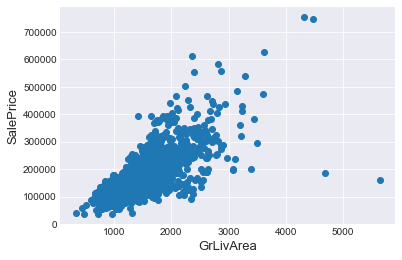

In [10]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

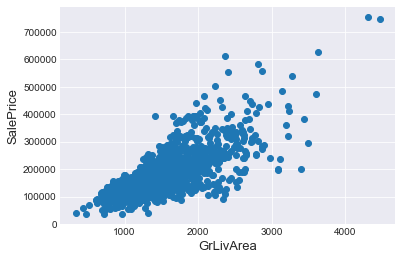

In [11]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

###Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

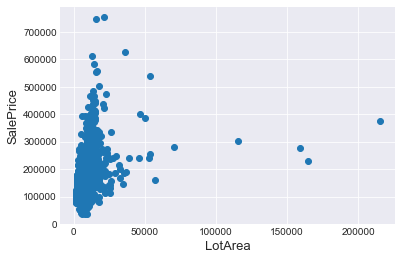

In [12]:

fig, ax = plt.subplots()
ax.scatter(x = train['LotArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

In [13]:
train.shape

(1458, 80)

In [14]:
train = train.drop(train[(train['LotArea']>100000)].index)


In [15]:
train.shape

(1454, 80)

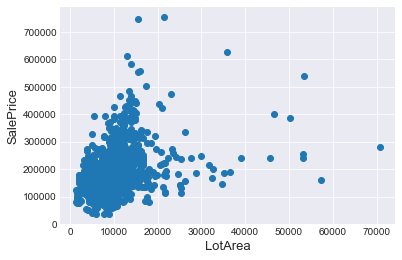

In [16]:
fig, ax = plt.subplots()
ax.scatter(x = train['LotArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

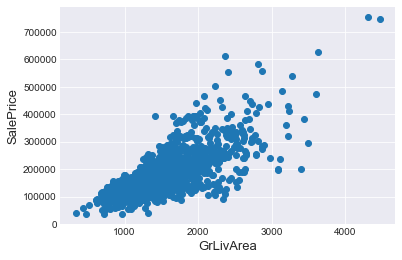

In [17]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [18]:
def plot_(df, target, column):
    fig, ax = plt.subplots()
    ax.scatter(df[column], df[target])
    plt.ylabel(target, fontsize=13)
    plt.xlabel(column, fontsize=13)
    plt.show()

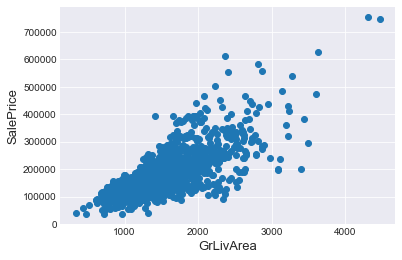

In [19]:
plot_(train, 'SalePrice', 'GrLivArea')

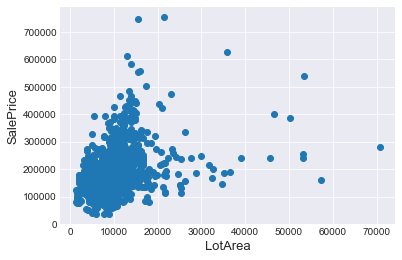

In [20]:
plot_(train, 'SalePrice', 'LotArea')

### Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180617.09 and sigma = 79299.98



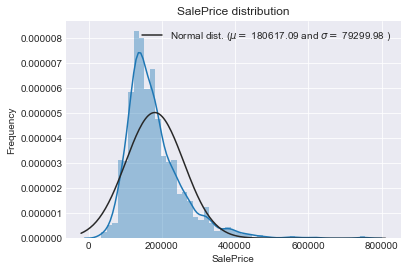

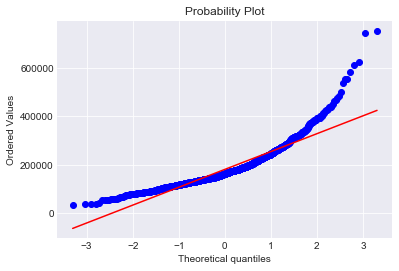

In [21]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

 **Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



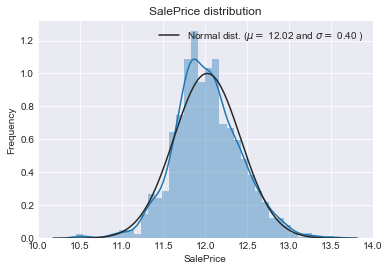

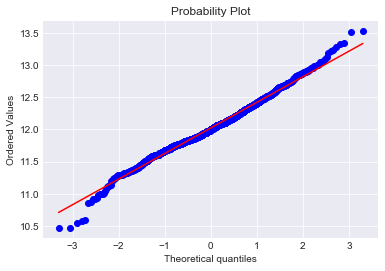

In [22]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

### Features engineering

let's first  concatenate the train and test data in the same dataframe

In [23]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2913, 79)


In [24]:
ntrain

1454

###Missing Data

In [25]:
train.groupby(['PoolQC']).count()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
PoolQC                                                                        
Ex               2         2            2        2       2      0         2   
Fa               2         2            2        2       2      0         2   
Gd               2         2            1        2       2      0         2   

        LandContour  Utilities  LotConfig    ...      ScreenPorch  PoolArea  \
PoolQC                                       ...                              
Ex                2          2          2    ...                2         2   
Fa                2          2          2    ...                2         2   
Gd                2          2          2    ...                2         2   

        Fence  MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  \
PoolQC                                                                         
Ex          2            0        2       2       2         2              2   
Fa          2            1        2       2       2         2              2   
Gd          2            0        2       2       2         2              2   

        SalePrice  
PoolQC             
Ex              2  
Fa              2  
Gd              2  

[3 rows x 79 columns]

In [26]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(30)

Missing Ratio
PoolQC               99.691
MiscFeature          96.464
Alley                93.203
Fence                80.398
FireplaceQu          48.747
LotFrontage          16.581
GarageQual            5.458
GarageCond            5.458
GarageFinish          5.458
GarageYrBlt           5.458
GarageType            5.390
BsmtExposure          2.815
BsmtCond              2.815
BsmtQual              2.781
BsmtFinType2          2.746
BsmtFinType1          2.712
MasVnrType            0.824
MasVnrArea            0.790
MSZoning              0.137
BsmtFullBath          0.069
BsmtHalfBath          0.069
Utilities             0.069
Functional            0.069
Electrical            0.034
BsmtUnfSF             0.034
Exterior1st           0.034
Exterior2nd           0.034
TotalBsmtSF           0.034
GarageArea            0.034
GarageCars            0.034

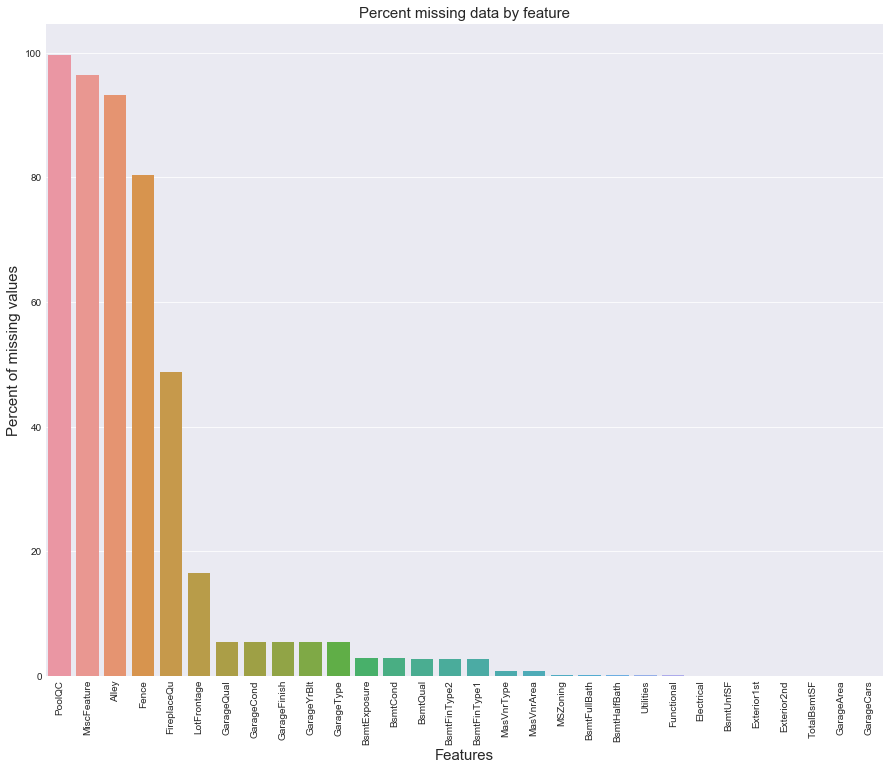

In [27]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


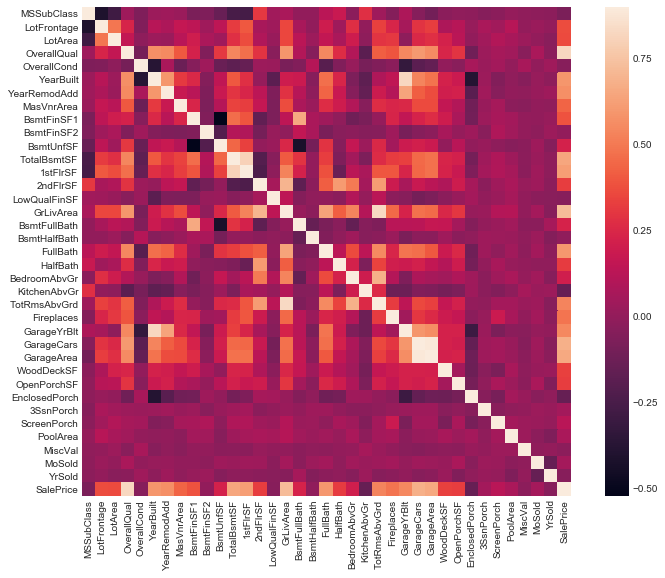

In [28]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [29]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : data description says NA means "no misc feature"


In [30]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [31]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [32]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [33]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [34]:
sum(all_data['LotFrontage'].isnull())

483

In [35]:
all_data.groupby("Neighborhood")["LotFrontage"].agg({'LotFrontage':'median'})

LotFrontage
Neighborhood             
Blmngtn            43.000
Blueste            24.000
BrDale             21.000
BrkSide            51.000
ClearCr            80.500
CollgCr            70.000
Crawfor            70.000
Edwards            64.500
Gilbert            64.000
IDOTRR             60.000
MeadowV            21.000
Mitchel            74.000
NAmes              73.000
NPkVill            24.000
NWAmes             80.000
NoRidge            89.000
NridgHt            92.000
OldTown            60.000
SWISU              60.000
Sawyer             72.000
SawyerW            67.000
Somerst            72.500
StoneBr            60.000
Timber             81.500
Veenker            80.000

In [36]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [37]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [38]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [39]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [40]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [41]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [42]:
all_data.iloc[225]['MSZoning']

'RM'

In [43]:
all_data.groupby(["Neighborhood",'MSZoning']).count()['1stFlrSF']

Neighborhood  MSZoning
Blmngtn       RL           25
              RM            3
Blueste       RM           10
BrDale        RM           30
BrkSide       RL           43
              RM           65
ClearCr       RL           42
CollgCr       RL          253
              RM           14
Crawfor       RH            2
              RL           91
              RM           10
Edwards       RH            2
              RL          178
              RM           12
Gilbert       RL          165
IDOTRR        C (all)      22
              RM           68
MeadowV       RM           37
Mitchel       RL          104
              RM            9
NAmes         RH            7
              RL          436
NPkVill       RL           23
NWAmes        RL          131
NoRidge       RL           71
NridgHt       RL          165
              RM            1
OldTown       C (all)       2
              RL           39
              RM          198
SWISU         C (all)       1
              RH 

In [44]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [45]:
all_data.groupby(['Utilities']).count()

1stFlrSF  2ndFlrSF  3SsnPorch  Alley  BedroomAbvGr  BldgType  \
Utilities                                                                 
AllPub         2910      2910       2910   2910          2910      2910   
NoSeWa            1         1          1      1             1         1   

           BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2   ...    \
Utilities                                                   ...     
AllPub         2910          2910        2910        2910   ...     
NoSeWa            1             1           1           1   ...     

           SaleCondition  SaleType  ScreenPorch  Street  TotRmsAbvGrd  \
Utilities                                                               
AllPub              2910      2909         2910    2910          2910   
NoSeWa                 1         1            1       1             1   

           TotalBsmtSF  WoodDeckSF  YearBuilt  YearRemodAdd  YrSold  
Utilities                                                            
AllPub            2910        2910       2910          2910    2910  
NoSeWa               1           1          1             1       1  

[2 rows x 78 columns]

In [46]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [47]:
all_data.groupby(['Functional']).count()

1stFlrSF  2ndFlrSF  3SsnPorch  Alley  BedroomAbvGr  BldgType  \
Functional                                                                 
Maj1              19        19         19     19            19        19   
Maj2               9         9          9      9             9         9   
Min1              65        65         65     65            65        65   
Min2              70        70         70     70            70        70   
Mod               35        35         35     35            35        35   
Sev                2         2          2      2             2         2   
Typ             2711      2711       2711   2711          2711      2711   

            BsmtCond  BsmtExposure  BsmtFinSF1  BsmtFinSF2   ...    \
Functional                                                   ...     
Maj1              19            19          19          19   ...     
Maj2               9             9           9           9   ...     
Min1              65            65          65          65   ...     
Min2              70            70          70          70   ...     
Mod               35            35          35          35   ...     
Sev                2             2           2           2   ...     
Typ             2711          2711        2711        2711   ...     

            SaleCondition  SaleType  ScreenPorch  Street  TotRmsAbvGrd  \
Functional                                                               
Maj1                   19        19           19      19            19   
Maj2                    9         9            9       9             9   
Min1                   65        65           65      65            65   
Min2                   70        70           70      70            70   
Mod                    35        35           35      35            35   
Sev                     2         2            2       2             2   
Typ                  2711      2710         2711    2711          2711   

            TotalBsmtSF  WoodDeckSF  YearBuilt  YearRemodAdd  YrSold  
Functional                                                            
Maj1                 19          19         19            19      19  
Maj2                  9           9          9             9       9  
Min1                 65          65         65            65      65  
Min2                 70          70         70            70      70  
Mod                  35          35         35            35      35  
Sev                   2           2          2             2       2  
Typ                2711        2711       2711          2711    2711  

[7 rows x 77 columns]

In [48]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [49]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [50]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [51]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [52]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [53]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



Is there any remaining missing value ? 

In [54]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

It remains no missing value.


### More features engeneering

**Transforming some numerical variables that are really categorical**

In [55]:
all_data.head()

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType BsmtCond  \
0       856       854          0  None             3     1Fam       TA   
1      1262         0          0  None             3     1Fam       TA   
2       920       866          0  None             3     1Fam       TA   
3       961       756          0  None             3     1Fam       Gd   
4      1145      1053          0  None             4     1Fam       TA   

  BsmtExposure  BsmtFinSF1  BsmtFinSF2  ...   SaleCondition SaleType  \
0           No     706.000       0.000  ...          Normal       WD   
1           Gd     978.000       0.000  ...          Normal       WD   
2           Mn     486.000       0.000  ...          Normal       WD   
3           No     216.000       0.000  ...         Abnorml       WD   
4           Av     655.000       0.000  ...          Normal       WD   

   ScreenPorch  Street TotRmsAbvGrd  TotalBsmtSF WoodDeckSF YearBuilt  \
0            0    Pave            8      856.000          0      2003   
1            0    Pave            6     1262.000        298      1976   
2            0    Pave            6      920.000          0      2001   
3            0    Pave            7      756.000          0      1915   
4            0    Pave            9     1145.000        192      2000   

  YearRemodAdd YrSold  
0         2003   2008  
1         1976   2007  
2         2002   2008  
3         1970   2006  
4         2000   2008  

[5 rows x 78 columns]

In [56]:
all_data['MSSubClass'].head()

0    60
1    20
2    60
3    70
4    60
Name: MSSubClass, dtype: int64

In [57]:
all_data['OverallCond'].head()

0    5
1    8
2    5
3    5
4    5
Name: OverallCond, dtype: int64

In [58]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
#all_data['MoSold'] = all_data['MoSold'].astype(str)



#### Transforming more numiercal variables

Summer holiday market is hot

In [59]:
#all_data['MoSold'] = all_data['MoSold'].astype(int)
all_data['Is_Summer'] = all_data['MoSold'].apply(lambda x: x in (5,6,7,8)).astype(int)
all_data['Is_Winter'] = all_data['MoSold'].apply(lambda x: x in (12,1)).astype(int)
all_data['Is_Other'] = all_data['MoSold'].apply(lambda x: x in (2,3,4,9,10,11)).astype(int)
all_data.drop(['MoSold'],1,inplace=True)

Age of the house

In [61]:
avg_price = train.groupby(['Neighborhood']).agg({'SalePrice':['sum'],'GrLivArea':['sum'] })

In [62]:
avg_price['avg_price'] = avg_price[('SalePrice', 'sum')]/avg_price[('GrLivArea', 'sum')]

In [63]:
avg_price

SalePrice GrLivArea avg_price
                   sum       sum          
Neighborhood                              
Blmngtn        206.880     24275     0.009
Blueste         23.653      2785     0.008
BrDale         184.766     18291     0.010
BrkSide        677.425     69778     0.010
ClearCr        317.567     46099     0.007
CollgCr       1824.547    222075     0.008
Crawfor        622.540     91372     0.007
Edwards       1147.122    123686     0.009
Gilbert        960.309    129664     0.007
IDOTRR         423.535     42265     0.010
MeadowV        195.067     18002     0.011
Mitchel        584.764     63416     0.009
NAmes         2670.312    294820     0.009
NPkVill        106.798     11277     0.009
NWAmes         885.535    126128     0.007
NoRidge        519.716    102863     0.005
NridgHt        971.695    147528     0.007
OldTown       1322.538    167209     0.008
SWISU          295.961     45031     0.007
Sawyer         874.049     89920     0.010
SawyerW        713.351     94106     0.008
Somerst       1057.499    137312     0.008
StoneBr        314.637     46977     0.007
Timber         444.636     62654     0.007
Veenker        135.786     16936     0.008

In [64]:
all_data['HouseAge'] = 2017 - all_data['YearBuilt']

In [65]:
all_data.drop(['YearBuilt'],1,inplace=True)

In [66]:
all_data[['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold']]

FireplaceQu BsmtQual BsmtCond GarageQual GarageCond ExterQual ExterCond  \
0           None       Gd       TA         TA         TA        Gd        TA   
1             TA       Gd       TA         TA         TA        TA        TA   
2             TA       Gd       TA         TA         TA        Gd        TA   
3             Gd       TA       Gd         TA         TA        TA        TA   
4             TA       Gd       TA         TA         TA        Gd        TA   
5           None       Gd       TA         TA         TA        TA        TA   
6             Gd       Ex       TA         TA         TA        Gd        TA   
7             TA       Gd       TA         TA         TA        TA        TA   
8             TA       TA       TA         Fa         TA        TA        TA   
9             TA       TA       TA         Gd         TA        TA        TA   
10          None       TA       TA         TA         TA        TA        TA   
11            Gd       Ex       TA         TA         TA        Ex        TA   
12          None       TA       TA         TA         TA        TA        TA   
13            Gd       Gd       TA         TA         TA        Gd        TA   
14            Fa       TA       TA         TA         TA        TA        TA   
15          None       TA       TA         TA         TA        TA        TA   
16            TA       TA       TA         TA         TA        TA        TA   
17          None     None     None         TA         TA        TA        TA   
18          None       TA       TA         TA         TA        TA        TA   
19          None       TA       TA         TA         TA        TA        TA   
20            Gd       Ex       TA         TA         TA        Gd        TA   
21            Gd       TA       TA         TA         TA        TA        TA   
22            Gd       Gd       TA         TA         TA        Gd        TA   
23            TA       Gd       TA         TA         TA        TA        TA   
24            TA       TA       TA         TA         TA        TA        Gd   
25            Gd       Gd       TA         TA         TA        Gd        TA   
26          None       TA       TA         TA         TA        TA        TA   
27            Gd       Ex       TA         TA         TA        Gd        TA   
28            Gd       TA       TA         TA         TA        TA        TA   
29          None       TA       TA         Fa         TA        TA        TA   
...          ...      ...      ...        ...        ...       ...       ...   
2883        None       TA       TA         TA         TA        TA        TA   
2884        None       TA       TA         TA         TA        TA        TA   
2885        None     None     None       None       None        TA        TA   
2886        None       TA       TA       None       None        Fa        Fa   
2887        None       Fa       Fa       None       None        TA        TA   
2888          Gd       Ex       TA         TA         TA        Gd        TA   
2889          Gd       Ex       TA         TA         TA        Gd        TA   
2890          TA       Gd       TA         TA         TA        TA        TA   
2891        None       TA       TA         TA         TA        TA        TA   
2892        None       Ex       TA         TA         TA        Gd        TA   
2893        None       TA       TA         TA         TA        TA        TA   
2894          Gd       Gd       TA         TA         TA        TA        TA   
2895        None       Gd       TA         TA         TA        Gd        TA   
2896          Gd       Ex       Gd         TA         TA        Gd        TA   
2897          Gd       Gd       TA         TA         TA        Ex        TA   
2898        None     None     None         Fa         TA        TA        Fa   
2899        None       Gd       TA         TA         TA        TA        Gd   
2900          TA       Gd       TA         TA         TA        TA        TA   
2901 

In [67]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))




Shape all_data: (2913, 80)


In [68]:
all_data[['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold']]

FireplaceQu  BsmtQual  BsmtCond  GarageQual  GarageCond  ExterQual  \
0               3         2         4           5           5          2   
1               5         2         4           5           5          3   
2               5         2         4           5           5          2   
3               2         4         1           5           5          3   
4               5         2         4           5           5          2   
5               3         2         4           5           5          3   
6               2         0         4           5           5          2   
7               5         2         4           5           5          3   
8               5         4         4           1           5          3   
9               5         4         4           2           5          3   
10              3         4         4           5           5          3   
11              2         0         4           5           5          0   
12              3         4         4           5           5          3   
13              2         2         4           5           5          2   
14              1         4         4           5           5          3   
15              3         4         4           5           5          3   
16              5         4         4           5           5          3   
17              3         3         2           5           5          3   
18              3         4         4           5           5          3   
19              3         4         4           5           5          3   
20              2         0         4           5           5          2   
21              2         4         4           5           5          3   
22              2         2         4           5           5          2   
23              5         2         4           5           5          3   
24              5         4         4           5           5          3   
25              2         2         4           5           5          2   
26              3         4         4           5           5          3   
27              2         0         4           5           5          2   
28              2         4         4           5           5          3   
29              3         4         4           1           5          3   
...           ...       ...       ...         ...         ...        ...   
2883            3         4         4           5           5          3   
2884            3         4         4           5           5          3   
2885            3         3         2           3           3          3   
2886            3         4         4           3           3          1   
2887            3         1         0           3           3          3   
2888            2         0         4           5           5          2   
2889            2         0         4           5           5          2   
2890            5         2         4           5           5          3   
2891            3         4         4           5           5          3   
2892            3         0         4           5           5          2   
2893            3         4         4           5           5          3   
2894            2         2         4           5           5          3   
2895            3         2         4           5           5          2   
2896            2         0         1           5           5          2   
2897            2         2         4           5           5          0   
2898            3         3         2           1           5          3   
2899            3         2         4           5           5          3   
2900            5         2         4           5           5          3   
2901            3         4         4           5           5          3   
2902            3         4         4           5           5          3   
2903            3         2         4           3     

**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [69]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Skewed features**

In [70]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



Skew
MiscVal       21.948
PoolArea      17.676
LowQualFinSF  12.076
3SsnPorch     11.364
LandSlope      4.955
KitchenAbvGr   4.297
BsmtFinSF2     4.159
EnclosedPorch  3.999
ScreenPorch    3.942
BsmtHalfBath   3.941

**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [71]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 61 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [73]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2913, 222)


Getting the new train and test sets. 

In [74]:
train = all_data[:ntrain]
test = all_data[ntrain:]


In [75]:
train.shape

(1454, 222)

In [76]:
test.shape

(1459, 222)

## Modelling

**Import librairies**

In [89]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb   #TianQi Chen
#import lightgbm as lgb



# Single_Model_RF

In [79]:
scaler = RobustScaler().fit(train)
X_train = scaler.transform(train)
X_test = scaler.transform(test) 

Use **cross validation** to tune the parameters of the model

In [85]:
import pandas as pd
import numpy as np
from sklearn import tree
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from math import log
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz # conda install gra... or pip install graphviz
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.grid_search import GridSearchCV
from time import time
from operator import itemgetter
from sklearn.cross_validation import  cross_val_score
def run_gridsearch(X, y, clf, param_grid,  cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 30)
    return  top_params


def report(grid_scores, n_top=30):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

In [86]:
print("-- Grid Parameter Search via 10-fold CV")

# set of parameters to test
param_grid = {"criterion": [ "mse"],
              "min_samples_split": [ 30],
              "max_depth": [4],
              "min_samples_leaf": [10],
              "n_estimators":[20,40]
              }

rf = RandomForestRegressor()

ts_gs = run_gridsearch(X_train, y_train, rf, param_grid, cv=3)

-- Grid Parameter Search via 10-fold CV

GridSearchCV took 1.09 seconds for 2 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.827 (std: 0.010)
Parameters: {'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.827 (std: 0.008)
Parameters: {'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 40}



In [87]:
print("\n-- Best Parameters:")
for k, v in ts_gs.items():
    print("parameter: {:<20s} setting: {}".format(k, v))


-- Best Parameters:
parameter: criterion            setting: mse
parameter: max_depth            setting: 4
parameter: min_samples_leaf     setting: 10
parameter: min_samples_split    setting: 30
parameter: n_estimators         setting: 20


In [91]:
# test the retuned best parameters
print("\n\n-- Testing best parameters [Grid]...")
dt_ts_gs = RandomForestRegressor(**ts_gs)
scores = cross_val_score(dt_ts_gs,X_train, y_train, cv=10)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )



-- Testing best parameters [Grid]...
mean: 0.825 (std: 0.024)



In [93]:
dt_ts_gs.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [95]:


sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('rf_2.csv',index=False)



**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

In [194]:
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

##Base models

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [195]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

again made robust to outliers

In [196]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Kernel Ridge Regression** :

In [197]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

In [198]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=6, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

In [199]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.03, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                              nthread = -1)



- **LightGBM** :

In [200]:
model_lgb = lgb.LGBMRegressor(xgb.XGBRegressor)

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [201]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1108 (0.0135)



In [202]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1107 (0.0136)



In [203]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1142 (0.0134)



In [204]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1176 (0.0166)



In [122]:

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1146 (0.0148)



In [123]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1135 (0.0148)



## Stacking  models

### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [205]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [125]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1070 (0.0142)



Wow ! It seems even the simplest stacking approach really improve the score . This encourages 
us to go further and explore a less simple stacking approch. 

### Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image taken from [Faron](https://www.kaggle.com/getting-started/18153#post103381))

![kaz](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif)

Gif taken from [KazAnova's interview](http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/)

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [126]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [127]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso,n_folds=10)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1065 (0.0145)


We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [128]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Final Training and Prediction

**StackedRegressor:**

In [129]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0752870994738


**XGBoost:**

In [130]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.075142511146


**LightGBM:**

In [131]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.0832348527089


In [132]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.0743263860259


**Ensemble prediction:**

In [206]:
ensemble = stacked_pred*0.71 + xgb_pred*0.14 + lgb_pred*0.15

**Submission**

In [207]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_final_2.csv',index=False)

In [213]:
import math
math.log2(100000)

16.609640474436812

In [222]:
n=100000000000000

In [223]:
(math.log2(n))**3

100589.995795967

In [224]:
n**0.5

10000000.0

In [225]:
5**(math.log2(n))

3.2136111711725783e+32

In [1]:
print("a")

a


In [3]:
import pandas as pd
ex = pd.read_excel('/Users/jitxu/Downloads/testingMMC.xlsx')

def to_xml(df, filename=None, mode='w'):
    def row_to_xml(row):
        xml = ['<item>']
        for i, col_name in enumerate(row.index):
            xml.append('  <field name="{0}">{1}</field>'.format(col_name, row.iloc[i]))
        xml.append('</item>')
        return '\n'.join(xml)
    res = '\n'.join(df.apply(row_to_xml, axis=1))

    if filename is None:
        return res
    with open(filename, mode) as f:
        f.write(res)
        
        
        
to_xml(ex,'foo.xml')

In [4]:
ex.head()

Gen_exnm             Gen_stid            Gen_Invnm  \
0  General Information  General Information  General Information   
1       Extractor Name           Study ID #   Author Name (Last)   
2               Merged              Ste1993                Steyn   
3               Merged              Ste1993                Steyn   
4               Merged              Ros1993              Rossouw   

             Gen_pubyr                          Gen_cmp  \
0  General Information              General Information   
1     Publication Year  Campaign Title\n(If applicable)   
2                 1993                            CORIS   
3                 1993                            CORIS   
4                 1993                            CORIS   

                                            Gen_pubt            Gen_Cntry  \
0                                General Information  General Information   
1                                  Publication Title         Country Name   
2  The intervention effects of a community-based ...         South Africa   
3  The intervention effects of a community-based ...         South Africa   
4  Community-Based Intervention: The Coronary Ris...         South Africa   

                                          Gen_desgn  \
0                               General Information   
1                                      Study Design   
2  Quasi-experimental with a separate control group   
3  Quasi-experimental with a separate control group   
4  Quasi-experimental with a separate control group   

                      Gen_odesgn                Gen_notes        ...          \
0            General Information      General Information        ...           
1  Specify if Other Study Design                    NOTES        ...           
2                            NaN  Cross-sectional surveys        ...           
3                            NaN  Cross-sectional surveys        ...           
4                            NaN  Cross-sectional surveys        ...           

                                        Unnamed: 195  \
0                                                NaN   
1  SE from CI or SE for difference between f/u in...   
2                                                NaN   
3                                                NaN   
4                                           0.141421   

                                        Unnamed: 196  \
0                                                NaN   
1  SE^2 (Will sqrt in final step) from SE or CI f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                      Unnamed: 197  \
0                              NaN   
1  SE of base to f/u (p-p) from SD   
2                         0.121415   
3                         0.138674   
4                              NaN   

                                        Unnamed: 198  \
0                                                NaN   
1  SE of change from baseline to f/u for int and ...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                        Unnamed: 199  \
0                                                NaN   
1  SE of difference between f/u int and f/u con (...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                        Unnamed: 200       Unnamed: 201  \
0                                                NaN                NaN   
1  SE^2 (need to sqrt in final step) of Change of...  SE of any P-value   
2                                          0.0309192                NaN   
3                                          0.0431471                NaN   
4                      

In [8]:
from lxml import etree

In [ ]:
import xlrd
from lxml import etree

root = etree.Element('network')
root.set('name', 'Network')
tree = etree.ElementTree(root)
name = etree.Element('nodes')
root.append(name)   
wb = xlrd.open_workbook("emme_nodes1.xls")
sh = wb.sheet_by_index(0)

for row in range(1, sh.nrows):
    val = sh.row_values(row)
    element = etree.SubElement(name, 'node')
    element.set('id', str(int(val[0])))
    element.set('x', str(val[1]))
    element.set('y', str(val[2]))
print etree.tostring(root,pretty_print=True)
